(1600, 1067, 3)


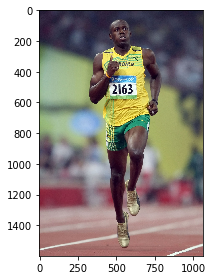

In [223]:
#importing required libraries
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage import exposure
import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline


#reading the image
img = imread('Usain-Bolt-2008.jpg')
imshow(img)
print(img.shape)

In [224]:
#resizing image 

training_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
training_gray = cv2.cvtColor(training_image, cv2.COLOR_RGB2GRAY)
resized_image = resize(training_gray, (128,64)) 
# imshow(resized_img) 
# print(resized_img.shape)

In [ ]:
class HOG:
    
    

# step 1 : calculate gradient

In [225]:
channel = resized_image
# imshow(channel)
g_row = np.empty(channel.shape, dtype=np.double)
g_row[0, :] = 0
g_row[-1, :] = 0
g_row[1:-1, :] = channel[2:, :] - channel[:-2, :]
g_col = np.empty(channel.shape, dtype=np.double)
g_col[:, 0] = 0
g_col[:, -1] = 0
g_col[:, 1:-1] = channel[:, 2:] - channel[:, :-2]
magnitude = np.hypot(g_col,g_row)
orientation = np.rad2deg(np.arctan2(g_row, g_col)) % 180

# now calculate the histogram cell-wise

In [226]:
unique_elements, counts_elements = np.unique(magnitude, return_counts=True)
print(unique_elements.shape)
print(counts_elements.shape)

(7438,)
(7438,)


In [227]:
pixels_per_cell = (8,8)
cells_per_block = (2,2)
orientations = 9
no_of_cells_x = resized_image.shape[1]//pixels_per_cell[1]
no_of_cells_y = resized_image.shape[0]//pixels_per_cell[0]
orientation_histogram = np.zeros((no_of_cells_y, no_of_cells_x, orientations))
orientation_histogram.shape

(16, 8, 9)

In [228]:
for row in range(no_of_cells_y):
    for col in range(no_of_cells_x):
        for i in range(pixels_per_cell[0]):
            for j in range(pixels_per_cell[1]):
                angle = orientation[i+row*pixels_per_cell[0]][j+col*pixels_per_cell[1]].astype(int)
                # fill the hist
                if(angle%20==0):
                    if(angle//20==9):
                        orientation_histogram[row][col][0] += magnitude[i+row*pixels_per_cell[0]][j+col*pixels_per_cell[1]]
                    else:
                        print(angle//20)
                        orientation_histogram[row][col][angle//20] += magnitude[i+row*pixels_per_cell[0]][j+col*pixels_per_cell[1]]
                else:
                    prev_bin = (angle//20) 
                    next_bin = (angle//20 + 1)
                        
                    prev_bin_mag = ((next_bin*20 - angle)/20)* magnitude[i+row*pixels_per_cell[0]][j+col*pixels_per_cell[1]]
                    next_bin_mag = ((angle - prev_bin*20)/20)* magnitude[i+row*pixels_per_cell[0]][j+col*pixels_per_cell[1]]
                    orientation_histogram[row][col][prev_bin] += prev_bin_mag
                    if(next_bin==9):
                        orientation_histogram[row][col][0] += next_bin_mag
                    else:
                        orientation_histogram[row][col][next_bin] += next_bin_mag


0
0
0
0
0
0
0
0
8
1
0
0
0
0
0
0
0
0
0
7
2
0
6
2
0
0
0
0
0
0
0
0
0
0
3
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
6
0
0
7
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
1
0
8
0
8
0
3
0
0
0
2
0
0
0
7
1
0
1
0
6
0
0
7
0
0
8
3
0
0
3
3
8
8
0
5
8
6
1
0
5
8
4
0
3
0
0
8
7
5
0
8
3
6
5
1
5
5
4
4
2
3
3
5
5
6
0
0
5
5
6
6
2
4
5
2
2
5
0
1
8
6
0
0
8
0
0
4
3
2
4
1
5
5
6
6
7
0
1
8
1
1
5
4
3
6
6
1
1
0
7
3
1
7
0
6
0
3
0
0
0
0
0
8
0
0
0
0
0
8
0
0
0
0
0
0
0
0
8
1
8
2
2
6
8
0
8
0
2
0
6
4
4
0
3
6
3
2
0
0
0
0
0
0
0
0
0
0
0
4
0
0
0
0
0
0
0
0
0
0
0
0
7
0
1
0
0
0
0
0
0
1
2
1
6
5
3
1
8
8
8
1
5
0
0
3
0
0
0
0
0
0
0
5
5
4
5
4
4
4
5
4
4
4
3
1
4
3
0
7
5
6
7
8
4
0
0
0
0
0
0
4
0
0
0
0
0
0
0
0
0
0
0
0
7
0
0
0
0
0
0
0
8
0
0
0
0
0
0
0
0
0
0
4
6
4
0
0
8
8
3
0
1
0
0
0
7
6
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
7
8
4
6
5
6
7
4
6
6
8
7
4
8
0
0
0
1
1
8
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [229]:
orientation_histogram[5:10]

array([[[1.73986767e-01, 2.91831653e-02, 1.66683837e-02, 3.60500965e-02,
         6.24532285e-01, 4.47874999e-01, 2.78520567e-01, 1.20713149e-01,
         9.28738068e-02],
        [1.13374918e-01, 4.60447628e-02, 3.21401016e-02, 1.80084734e-01,
         6.31507921e-01, 4.88547554e-01, 9.63455106e-03, 2.95152265e-02,
         6.13155428e-02],
        [3.78838963e+00, 2.12997151e+00, 3.04720868e+00, 7.99366249e-01,
         0.00000000e+00, 0.00000000e+00, 7.96723501e-02, 5.96434775e-01,
         1.75040632e+00],
        [2.80164181e+00, 4.40386534e+00, 4.21236069e+00, 1.46229444e+00,
         1.30533049e+00, 1.12958627e+00, 5.51810229e-01, 6.79247365e-01,
         1.04773736e+00],
        [1.20940788e+00, 1.69661639e+00, 1.10272700e+00, 1.34808624e+00,
         2.05508713e+00, 2.18343869e+00, 5.17886293e-01, 5.92107376e-01,
         1.14793368e+00],
        [3.57985026e+00, 3.68192882e+00, 5.79203814e-01, 7.01326789e-02,
         3.98535309e-02, 1.03432667e-01, 1.21742564e-01, 4.19871853

In [230]:
final_feature = []
print(orientation_histogram[0:1][0:1].shape)
for i in range(orientation_histogram.shape[0]-1):
    for j in range(orientation_histogram.shape[1]-1):
        #now we are in a cell
#         v=np.sum(hog_feature[i*8:(i+2)*8][j*8:(j+2)*8]**2)
#         copy_hog=hog_feature[i*8:(i+2)*8][j*8:(j+2)*8]
#         v=np.sum(orientation_histogram[i:(i+cells_per_block[0]),j:(j+cells_per_block[0])]**2)
        v=np.sqrt(np.sum(np.square(orientation_histogram[i:(i+cells_per_block[0]),j:(j+cells_per_block[1])])))
        print(v)
        copy_hog=orientation_histogram[i:(i+cells_per_block[0]),j:(j+cells_per_block[0])]
        if(v!=0):
            copy_hog/=v
        final_feature.append(copy_hog.reshape(36))
feature_vector = list(np.concatenate(final_feature).flat)
print(copy_hog.shape)

(1, 8, 9)
2.297603930337516
1.9191189453923794
3.0469342592592774
1.8941187692955805
1.5800382750936524
1.5788729830720483
1.3524853755193686
4.589445115847049
2.4194214050830847
4.794768197178895
4.610211305224737
2.386149334176151
1.5039368191741287
1.7088805059768375
2.8107606202693547
3.728812859274219
6.926125289114562
3.0137582321443226
7.383246403896888
2.58380620672949
2.0405747992226906
0.7038521446679024
3.8051934307119737
6.085729589914135
3.2136500263871928
6.989818106567295
2.275020526838725
2.06284143284115
1.3179089558328403
5.715726159194949
7.283584852954515
4.393375055970217
5.751913788628323
2.9819231265336112
2.168201378357257
5.811338719111466
3.2741989442146795
2.2900561862480737
2.408226139031924
5.561431624283536
2.4193290712123208
2.117437833864877
1.3027436987691268
1.222166561316772
2.6743555448763296
4.500447253210587
2.2412354723444747
1.392940492669606
2.797795234431173
3.2685301511607707
2.8138815282609895
5.064666565888431
5.0413290321398
2.8539852385237

In [231]:
hog_np = np.array(feature_vector)

In [232]:
from skimage.feature import hog
fd, hog_image = hog(resized_image, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True,)



In [195]:
fd.shape

(138744,)

In [242]:
def visualize_hog(im, hog, cell_size, block_size):
    num_bins = 9
    max_len = 7  # control sum of segment lengths for visualized histogram bin of each block
    im_h, im_w = im.shape
    num_cell_h, num_cell_w = int(im_h / cell_size), int(im_w / cell_size)
    num_blocks_h, num_blocks_w = num_cell_h - block_size + 1, num_cell_w - block_size + 1
    histo_normalized = hog.reshape((num_blocks_h, num_blocks_w, block_size**2, num_bins))
    histo_normalized_vis = np.sum(histo_normalized**2, axis=2) * max_len  # num_blocks_h x num_blocks_w x num_bins
    angles = np.arange(0, np.pi, np.pi/num_bins)
    mesh_x, mesh_y = np.meshgrid(np.r_[cell_size: cell_size*num_cell_w: cell_size], np.r_[cell_size: cell_size*num_cell_h: cell_size])
    mesh_u = histo_normalized_vis * np.sin(angles).reshape((1, 1, num_bins))  # expand to same dims as histo_normalized
    mesh_v = histo_normalized_vis * -np.cos(angles).reshape((1, 1, num_bins))  # expand to same dims as histo_normalized
    plt.imshow(im, cmap='gray', vmin=0, vmax=1)
    for i in range(num_bins):
        plt.quiver(mesh_x - 0.5 * mesh_u[:, :, i], mesh_y - 0.5 * mesh_v[:, :, i], mesh_u[:, :, i], mesh_v[:, :, i],
                   color="white", headaxislength=0, headlength=0, scale_units='xy', scale=1, width=0.002, angles='xy')
    plt.show()



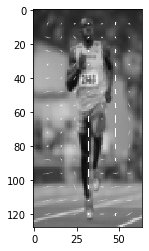

In [243]:
visualize_hog(resized_image,hog_np,8,2)

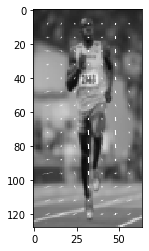

In [244]:
visualize_hog(resized_image,fd,8,2)

In [124]:
print(hog_np[50:100])
fd[50:100]

[1.14303399e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.57421640e-04 0.00000000e+00 1.73750743e-04 5.79169142e-05
 5.85049183e-05 5.85049183e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.95948685e-03 0.00000000e+00 3.46391609e-04
 1.15463870e-04 4.89871711e-04 4.89871711e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 6.16285412e-04 0.00000000e+00
 1.28086424e-06 4.26954746e-07 7.04439391e-07 7.04439391e-07
 0.00000000e+00 0.00000000e+00 0.00000000e+00 9.49085215e-01
 0.00000000e+00 7.19040634e-03 2.39680211e-03 3.08144550e-04
 3.08144550e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.20761039e-06 0.00000000e+00 2.13477373e-07 7.11591244e-08
 3.01902596e-07 3.01902596e-07 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.14926147e-01]


array([0.        , 0.        , 0.        , 0.        , 0.00579394,
       0.00377988, 0.02674119, 0.00166251, 0.02591623, 0.        ,
       0.        , 0.        , 0.        , 0.55895011, 0.55895011,
       0.55895011, 0.02280457, 0.00610881, 0.03527761, 0.0606278 ,
       0.02228118, 0.02617381, 0.0012244 , 0.00058091, 0.08495141,
       0.05550358, 0.02865755, 0.        , 0.        , 0.        ,
       0.        , 0.00208039, 0.        , 0.36122328, 0.36122328,
       0.11217772, 0.03787731, 0.00942929, 0.        , 0.00107044,
       0.36122328, 0.36122328, 0.36122328, 0.01074651, 0.00287874,
       0.01662435, 0.02857048, 0.01049987, 0.01233424, 0.18551321])

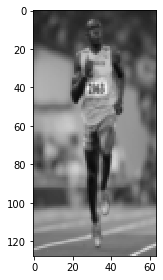

In [238]:
imshow(resized_image)